In [1]:
import os

#add the root directory
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loader import *
import h5py
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import matplotlib.lines as mlines
from PCAfold import normalized_variance_derivative, cost_function_normalized_variance_derivative
import re
from matplotlib import gridspec
import matplotlib.cm as cm
from matplotlib.lines import Line2D

from os import listdir
from os.path import isfile, join
from scipy.io import loadmat
from tools import *
import logging
from utils import *

logging.disable(logging.CRITICAL) #disable the logging

# Figures 3: Encoder-decoder with linear vs. log decoded QoIs

In [3]:
path_variance = "data-files/costs/"

name_without = "variance_Tr0D-2h_s0-bw_-6_2_100-dataset_autoignition.npy"
name_with = "variance_Tr0D-2s_s2-bw_-6_2_100-dataset_autoignition.npy"

penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

variance_without = np.load(f"{path_variance}{name_without}", allow_pickle=True).item()
variance_with = np.load(f"{path_variance}{name_with}", allow_pickle=True).item()

(derivative_without, bandwidth_values_without, max_derivative_without) = normalized_variance_derivative(variance_without)
(derivative_with, bandwidth_values_with, max_derivative_with) = normalized_variance_derivative(variance_with)

keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

costsWithout = cost_function_normalized_variance_derivative(variance_without,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)
costsWith = cost_function_normalized_variance_derivative(variance_with,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)

MSEWithout = np.load("paper/data/MSE_QoIs_val_NN_Tr0D-2h_autoignition_s7_epo500_lr0.01_scaleManifoldTrue.npy")
MSEWith = np.load("paper/data/MSE_QoIs_val_NN_Tr0D-2s_autoignition_s7_epo500_lr0.01_scaleManifoldTrue.npy")

In [4]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"

#create all the datasets
mixture_fractions_train_0D = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fraction.csv") #1 x nbr_timesteps
mixture_fractions_test = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)
state_space_train_0D = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space.csv", names = state_space_names)
state_space_source_train_0D = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space-sources.csv", names = state_space_names)
time_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}time.csv") #1 x nbr_timesteps


filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s2"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model_0D = loader.metadata["Training_id"]
model_0D = loader.loadModel()

weight_inversion = False  #True for q and False for s
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_0D.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

#create a np array in the format for the DNS dataset/optimized PV
state_space_train_DNS = state_space_train_0D[state_space_names_DNS].to_numpy()
state_space_source_train_DNS = state_space_source_train_0D[state_space_names_DNS].to_numpy()
print(state_space_source_train_DNS.shape)

PV_optimized_train_0D = model_0D.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
PV_optimized_source_train_0D = model_0D.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()


filename_model_without = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0"
filename_metadata_without = filename_model_without + "_metadata.pkl"
path_metadata_without = "metadata/"

loader_without = loadData(filename_species_names, path_metadata_without, filename_metadata_without)
idx_species_removed_without = loader_without.metadata["list idx species removed source"] if loader_without.metadata["dataset_type"].startswith("autoignition_augm") else loader_without.metadata["idx species removed"]
id_model_0D_without = loader_without.metadata["Training_id"]
model_0D_without = loader_without.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_0D_without.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

PV_optimized_train_0D_without = model_0D_without.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed_without, axis=1))).detach().numpy()
PV_optimized_source_train_0D_without = model_0D_without.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed_without, axis=1))).detach().numpy()

(241519, 21)


In [5]:
keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', '$\dot{\omega}_{\mathrm{PV}}$']
keys = [k.replace("2", "$_2$") for k in keys]

greys = cm.get_cmap('Greys')

# Convert to numpy arrays
MSE_without = np.array(MSEWithout)
MSE_with    = np.array(MSEWith)
Cost_without = np.array(costsWithout)
Cost_with    = np.array(costsWith)
features = np.array(keys)

# Compute difference in MSE (absolute change)
delta_MSE = np.abs(np.log(MSE_with) - np.log(MSE_without))

# Sort features by delta_MSE (largest first)
order = np.argsort(delta_MSE)

# Reorder all arrays
features_sorted = features[order]
MSE_without_sorted = MSE_without[order]
MSE_with_sorted = MSE_with[order]
Cost_without_sorted = Cost_without[order]
Cost_with_sorted = Cost_with[order]

# Sub-line vertical offsets
subline_offset = 0.15

C:\Windows\Temp\ipykernel_4008\1233464903.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


C:\Windows\Temp\ipykernel_4008\2428883379.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')
C:\Windows\Temp\ipykernel_4008\2428883379.py:216: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


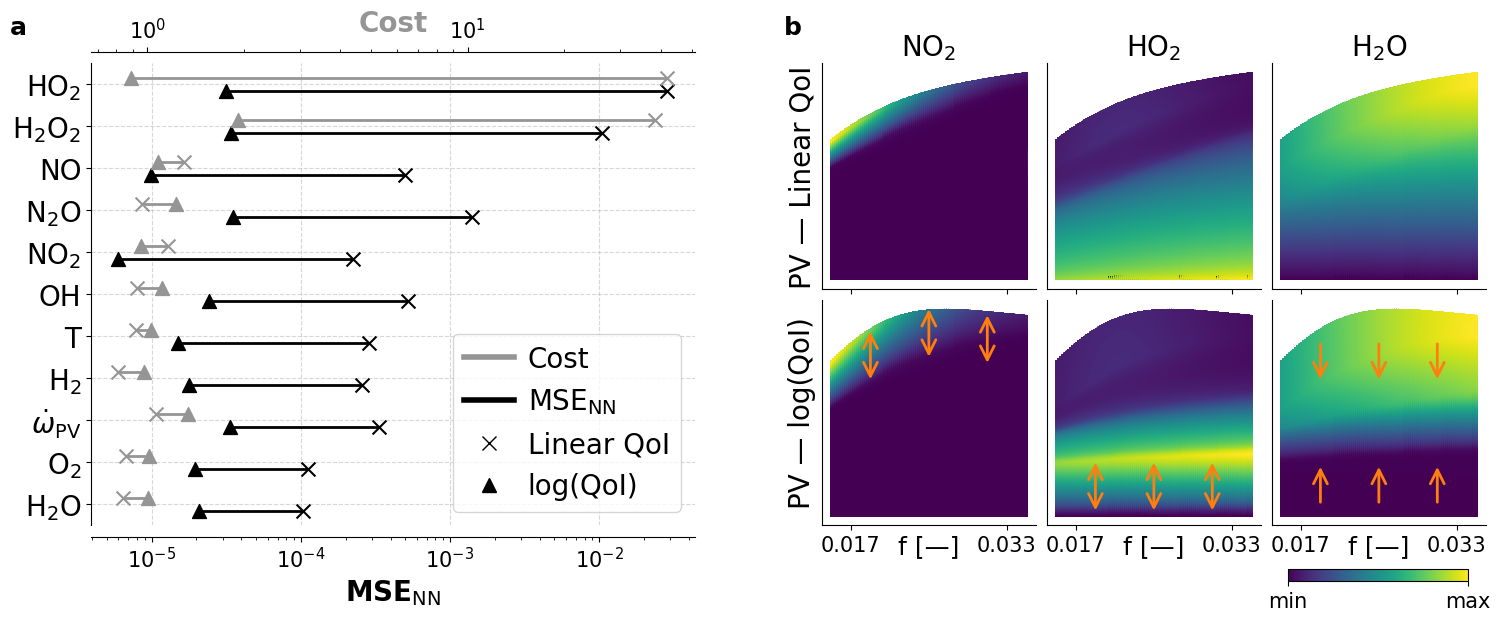

In [13]:
save = False
pathSave = f"C:/Users/Admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/"
nameSave = f"Figure 3 - linear vs. log QoIs"

def add_panel_label(ax, label, x_offset=-0.12, y_offset=1.08, fontsize=18):
    ax.text(
        x_offset, y_offset,
        label,
        transform=ax.transAxes,
        fontsize=fontsize,
        fontweight="bold",
        va="top",
        ha="left",
        clip_on=False
    )

def plot_left_panel(ax_mse):
    greys = cm.get_cmap('Greys')

    ax_cost = ax_mse.twiny()

    for i, feature in enumerate(features_sorted):
        y_center = i

        # --- MSE ---
        y = y_center - subline_offset
        ax_mse.plot([MSE_without_sorted[i], MSE_with_sorted[i]], [y, y],
                    color="k", linewidth=2)
        ax_mse.scatter(MSE_without_sorted[i], y, color="k", marker="x", s=100, zorder=4)
        ax_mse.scatter(MSE_with_sorted[i], y, color="k", marker="^", s=100, zorder=5)

        # --- Cost ---
        y = y_center + subline_offset
        ax_cost.plot([Cost_without_sorted[i], Cost_with_sorted[i]], [y, y],
                     color=greys(0.5), linewidth=2)
        ax_cost.scatter(Cost_without_sorted[i], y, color=greys(0.5), marker="x", s=100)
        ax_cost.scatter(Cost_with_sorted[i], y, color=greys(0.5), marker="^", s=100)

    ax_mse.set_yticks(range(len(features_sorted)))
    ax_mse.set_yticklabels(features_sorted, fontsize=20)

    ax_mse.set_xlabel("MSE$_{\mathrm{NN}}$", fontsize=20, fontweight="bold")
    ax_cost.set_xlabel("Cost", fontsize=20, color=greys(0.5),
                       labelpad=-10, fontweight="bold")

    ax_mse.set_xscale("log")
    ax_cost.set_xscale("log")

    ax_mse.grid(axis='both', linestyle='--', alpha=0.5)
    ax_mse.tick_params(axis="x", labelsize=15)
    ax_cost.tick_params(axis="x", labelsize=15)

    ax_mse.set_ylim(-0.5, len(features_sorted) - 0.5)

    # Spines
    ax_mse.spines['top'].set_visible(False)
    ax_mse.spines['right'].set_visible(False)
    ax_cost.spines['right'].set_visible(False)
    ax_cost.spines['left'].set_visible(False)
    ax_cost.spines['bottom'].set_visible(False)

    offset = 8
    ax_mse.spines['bottom'].set_position(('outward', offset))
    ax_cost.spines['top'].set_position(('outward', offset))

    # Legend (unchanged)
    legend_elements = [
        Line2D([0], [0], color=greys(0.5), linestyle="-", lw=4, label="Cost"),
        Line2D([0], [0], color="k", linestyle="-", lw=4, label="MSE$_{\mathrm{NN}}$"),
        Line2D([0], [0], color="k", marker="x", lw=0, markersize=10, label="Linear QoI"),
        Line2D([0], [0], color="k", marker="^", lw=0, markersize=10, label="log(QoI)")
    ]
    ax_mse.legend(handles=legend_elements, fontsize=20,
                  loc="lower right", handletextpad=0.5, handlelength=1.8)

def plot_right_panel(axes):
    rows, cols = axes.shape

    for idxKey, key in enumerate(keys):
        if key == "PV1":
            colorSpecies = PV_optimized_source_train_0D
        else:
            colorSpecies = state_space_train_0D[key]

        sc0 = axes[0, idxKey].scatter(
            mixture_fractions_train_0D,
            PV_optimized_train_0D_without,
            c=colorSpecies, cmap="viridis", s=1
        )

        sc1 = axes[1, idxKey].scatter(
            mixture_fractions_train_0D,
            PV_optimized_train_0D,
            c=colorSpecies, cmap="viridis", s=1
        )

        
        axes[0, idxKey].set_yticks([])
        axes[1, idxKey].set_yticks([])

        axes[0, idxKey].set_title(nameCols[idxKey], fontsize=20)

        axes[1, idxKey].set_xlabel("f [\u2014]", fontsize = 18, labelpad = -15)
        axes[0, idxKey].set_xticks([0.017, 0.033])
        axes[0, idxKey].set_xticklabels([])
        axes[1, idxKey].set_xticks([0.017, 0.033])
        axes[1, idxKey].tick_params(axis = "x", labelsize = 15)


        if idxKey == 0:
            axes[0, idxKey].set_ylabel("PV \u2014 Linear QoI", fontsize=20)
            axes[1, idxKey].set_ylabel("PV \u2014 log(QoI)", fontsize=20)

        x_arrows = [0.019, 0.025, 0.031]

        # reference max value
        y_max = PV_optimized_train_0D.max()

        # Bottom arrows (pointing upward)
        y_start_bottom = 0.05 * y_max
        y_end_bottom   = 0.25 * y_max

        # Top arrows (pointing downward)
        y_start_top = 0.85 * y_max
        y_end_top   = 0.65 * y_max

        arr_y_start_top = [0.87 * y_max, 0.98 * y_max, 0.95 * y_max]
        arr_y_end_top = [0.67 * y_max, 0.78 * y_max, 0.75 * y_max]

        margin = 0.02 * y_max

        for idxArrow, x in enumerate(x_arrows):
            # Bottom arrows
            if(idxKey == 1):
                axes[1, idxKey].annotate(
                    "",
                    xy=(x, y_end_bottom + margin),
                    xytext=(x, y_start_bottom - 2*margin),
                    arrowprops=dict(
                        arrowstyle="<->",
                        lw=2,
                        color="tab:orange",
                        mutation_scale=25
                    )
                )
            if(idxKey == 2):
                # Top arrows
                axes[1,idxKey].annotate(
                    "",
                    xy=(x, y_end_top),
                    xytext=(x, y_start_top),
                    arrowprops=dict(
                        arrowstyle="->",
                        lw=2,
                        color="tab:orange",
                        mutation_scale=25
                    )
                )

                axes[1, idxKey].annotate(
                    "",
                    xy=(x, y_end_bottom),
                    xytext=(x, y_start_bottom),
                    arrowprops=dict(
                        arrowstyle="->",
                        lw=2,
                        color="tab:orange",
                        mutation_scale=25
                    )
                )
            if(idxKey == 0):
                # Top arrows
                axes[1,idxKey].annotate(
                    "",
                    xy=(x, arr_y_end_top[idxArrow] - margin),
                    xytext=(x, arr_y_start_top[idxArrow] + 2*margin),
                    arrowprops=dict(
                        arrowstyle="<->",
                        lw=2,
                        color="tab:orange",
                        mutation_scale=25
                    )
                )

    for ax in axes.flatten():
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    return sc1

fig = plt.figure(figsize=(18, 6))

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.1], hspace = 0.25)

ax_left = fig.add_subplot(gs[0, 0])

keys = ['NO2', 'HO2', 'H2O']
nameCols = ['NO$_2$', 'HO$_2$', 'H$_2$O']
keysYaxis = [r"$Y_{NO}$"+ " [\u2014]", r"$Y_{H_2O_2}$"+ " [\u2014]",r"$\dot{\omega}_{\mathrm{PV}}$"+ " [1/s]"]

# Right panel needs a 2×N grid
subgs = gs[0, 1].subgridspec(2, len(keys), hspace=0.05, wspace=0.05)
axes_right = np.array([[fig.add_subplot(subgs[i, j]) for j in range(len(keys))]
                        for i in range(2)])

plot_left_panel(ax_left)
sc = plot_right_panel(axes_right)

# --- Add right panel colorbar ---
cax = fig.add_axes([0.79, 0.017, 0.1, 0.02])
cbar = fig.colorbar(sc, cax=cax, orientation='horizontal')
cbar.set_ticks([sc.get_array().min(), sc.get_array().max()])
cbar.set_ticklabels(["min", "max"])
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()

fig.text(
    0.08, 0.96,  # x, y in figure coordinates (0..1)
    "a",
    fontsize=18,
    fontweight="bold",
    va="top",
    ha="left"
)

fig.text(
    0.51, 0.96,  # adjust to position over right panel
    "b",
    fontsize=18,
    fontweight="bold",
    va="top",
    ha="left"
)

if save:
    plt.savefig(pathSave + nameSave + ".png", dpi=1000, bbox_inches="tight")

plt.show()